In [62]:
import pandas as pd
import requests
import requests_cache
import re
import lxml.html as lx
from bs4 import BeautifulSoup
import time
import sys
import datetime
import plotnine as p9
import numpy as np
import bokeh
from bokeh.plotting import figure, show
import bokeh.models
import bokeh.io
import imageio
import folium

In [130]:
# Reading the California State Geoportal biodiversity data for 2021 using documented API

In [91]:
url = 'https://services2.arcgis.com/Uq9r85Potqm3MfRV/arcgis/rest/services/biosds2769_fpu/FeatureServer/0/query?where=1%3D1&outFields=*&outSR=4326&f=json'

result = requests.get(url)
html = BeautifulSoup(result.text, 'lxml')
data_list = result.json()['features']

In [92]:
data_dict = []

for dict in data_list:
    data_dict.append(dict['attributes'])

In [94]:
bio_df = pd.DataFrame(data_dict)
bio_df.head(n = 50)

,OBJECTID,Hex_ID,HUC12,Name,SpBioRnkEco,SpBioWtEco,SpBioRnkSW,BioTrRnkEco,BioTrRnkSW,BioAqRnkSW,...,TerrConnRank,TerrClimRank,TerrHabRank,AqHabRank,Eco_Sect,Eco_Name,Jepson_Eco,County,Shape__Area,Shape__Length
0,1,100,171003090103,Dutch Creek-Elliott Creek,2,0.340206,4,4,5,3,...,3,5,1,2,M261A,Klamath Mountains,KR,SISKIYOU,5.049239e+06,9872.784007
1,2,100,171003090104,Middle Fork Applegate River-Applegate River,3,0.343531,4,4,5,3,...,3,5,1,3,M261A,Klamath Mountains,KR,SISKIYOU,6.680387e+06,11435.898914
2,3,1000,180102040103,Mosquito Creek-Willow Creek,4,0.430505,4,5,4,2,...,4,2,2,3,M261G,Modoc Plateau,MP,MODOC,1.168921e+07,12726.884954
3,4,10000,180101070208,North Fork Mattole River,2,0.360931,5,3,5,5,...,3,1,2,3,263A,Northern California Coast,NCo,HUMBOLDT,4.055132e+06,9129.225722
4,5,10000,180101070302,Davis Creek-Frontal Pacific Ocean,2,0.355134,5,3,5,4,...,3,1,2,4,263A,Northern California Coast,NCo,HUMBOLDT,1.136533e+06,4273.504254
5,6,10000,180101070209,Lower Mattole River,2,0.377675,5,3,5,5,...,3,1,2,4,263A,Northern California Coast,NCo,HUMBOLDT,5.962164e+06,10133.259064
6,7,10001,180101070208,North Fork Mattole River,2,0.333662,5,2,5,5,...,1,3,1,3,263A,Northern California Coast,NCo,HUMBOLDT,9.458013e+05,5778.367099
7,8,10001,180101070209,Lower Mattole River,2,0.350406,5,2,5,5,...,1,3,1,4,263A,Northern California Coast,NCo,HUMBOLDT,1.020855e+07,12297.145298
8,9,10002,180101070208,North Fork Mattole River,2,0.326295,5,2,5,5,...,1,2,2,3,263A,Northern California Coast,NCoRO,HUMBOLDT,4.663132e+06,10158.961627
9,10,10002,180101070209,Lower Mattole River,2,0.343039,5,2,5,5,...,1,2,2,4,263A,Northern California Coast,NCoRO,HUMBOLDT,6.491807e+06,10948.192552


In [95]:
bio_df_subset = bio_df.groupby(['County']).agg({'SpBioRnkEco': 'sum'}).reset_index()
bio_df_subset

,County,SpBioRnkEco
0,DEL NORTE,145
1,HUMBOLDT,681
2,LASSEN,1318
3,MODOC,265
4,PLUMAS,581
5,SHASTA,154
6,SISKIYOU,253
7,TEHAMA,2338
8,TRINITY,664


In [2]:
def convert_dotnet_date(dotnet_date):
    ms = int(dotnet_date)
    seconds = ms / 1000
    # Returns in the form of year, month, day, hour (24 hour format), minute
    return datetime.datetime.utcfromtimestamp(seconds)

In [131]:
def get_fire_data(year: int):
    start_time = time.time()
    url = 'https://www.fire.ca.gov/api/sitecore/Incident/GetFiresByYear'

    payload = {'year': year}
    headers = {'Origin': 'https://www.fire.ca.gov',
               'Referer': 'https://www.fire.ca.gov/incidents/' + str(year),
               'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36'}

    result = requests.post(url, headers = headers, params = payload)
    full_df = pd.DataFrame(result.json())

    # Create these columns for data to be inputted into them later
    full_df['Extinguished_Date'] = None
    full_df['Started_Date'] = None
    
    for index, incident_url in enumerate(full_df['Url']):  # Iterate through each fire's outlink
        
        time.sleep(1/50)
        url = 'https://www.fire.ca.gov/api/sitecore/Incident/GetSingleFire'
        payload = {'IncidentUrl': incident_url}
        headers = {'Origin': 'https://www.fire.ca.gov',
                   'Referer': 'https://www.fire.ca.gov' + incident_url,
                   'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36'}
        result = requests.post(url, headers = headers, params = payload)
        
        try:
            result_dict = result.json()
        except:
            continue

        # [6:-2] to omit unecessary digits
        started = result_dict['Started'][6:-2]
        extinguished = result_dict['ExtinguishedDate'][6:-2]

        # Check to see if the dates are readable
        if started[0] == '-':
            started = None
        else:
            started = convert_dotnet_date(started)
        if extinguished[0] == '-':
            extinguished = None
        else:
            extinguished = convert_dotnet_date(extinguished)
        
        full_df.loc[index, 'Started_Date'] = started
        full_df.loc[index, 'Extinguished_Date'] = extinguished
    
    print(time.time() - start_time)
    return full_df

In [4]:
years = ['2023', '2022', '2021', '2020', '2019', '2018', '2017', '2016']
fire_dfs = []

for year in years:
    fire_dfs.append(get_fire_data(year))

fire_df = pd.concat(fire_dfs, ignore_index=True)

88.09971356391907
103.59160900115967
125.88050389289856
176.12892985343933
185.54531335830688
223.94982242584229
294.18607687950134
123.06199169158936


In [137]:
fire_df

,Name,Updated,Started,AdminUnit,County,Location,AcresBurned,PercentContained,Longitude,Latitude,Type,UniqueId,Url,StartedDateOnly,IsActive,ExternalUrl,Extinguished_Date,Started_Date,Total_Burn_Time,Year
0,Nob Fire,2023-05-10,2023-04-26,San Bernardino National Forest,San Bernardino,"East Blue Ridge and Paiute, south of Wrightwood",0.0,0.0,-117.565833,34.293103,None,8cd5adf0-00de-4f9c-9d5d-2637f7c0972e,/incidents/2023/4/26/nob-fire/,None,False,https://inciweb.nwcg.gov/incident-information/...,None,2023-04-26 10:16:00,None,2023.0
0,66 Fire,2023-05-28,2023-05-15,CAL FIRE Riverside Unit,Riverside,Ave 66 and Hwy 86,127.0,100.0,-116.092746,33.569342,None,a56115f1-5eca-4dc1-b576-cbeb67ed4b5b,/incidents/2023/5/15/66-fire/,None,False,,2023-05-18 19:00:00,2023-05-15 12:10:00,None,2023.0
0,Johnson Fire,2023-05-23,2023-05-20,CAL FIRE / Riverside County Fire and Bureau of...,Riverside,"Johnson Street and 81st Avenue, Mecca",0.0,0.0,-116.0614,33.4626,None,372264df-a6df-41b0-91b1-6b1ed6547a11,/incidents/2023/5/20/johnson-fire/,None,False,,2023-05-23 10:23:13,2023-05-20 20:34:18,None,2023.0
0,Point Fire,2023-05-23,2023-05-21,CAL FIRE Shasta - Trinity Unit,Shasta,"Two Feathers Road and Wagon Gulch Road, 13 mil...",10.0,100.0,-122.47542,40.417676,None,c2deabb9-7935-4a0a-8fba-4d4005e4bf1c,/incidents/2023/5/21/point-fire/,None,False,,None,2023-05-21 17:45:00,None,2023.0
0,Ramona Fire,2023-12-05,2023-05-22,Riverside County Fire,Riverside,Ramona Expressway and N Warren Rd,348.0,100.0,-117.033714,33.823424,None,e44f5b6b-c6e6-461a-a9ab-d442e08de3ea,/incidents/2023/5/22/ramona-fire/,None,False,https://www.rvcfire.org/incidents/fact-sheets/...,2023-05-25 20:00:10,2023-05-22 14:11:00,None,2023.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,Emerald Fire,2016-10-17,2016-10-14,CAL FIRE Amador- El Dorado Unit / USFS El Dora...,El Dorado,"off Highway 89, near Cascade Lake and Emerald ...",176.0,100.0,-120.10744,38.93449,None,81ef7517-ab3c-4d1a-8ddd-b5d69404676f,/incidents/2016/10/14/emerald-fire/,None,False,,2016-10-17 11:45:00,2016-10-14 01:28:00,None,2016.0
0,Gopher Fire,2016-11-14,2016-11-13,CAL FIRE San Diego Unit,San Diego,Off Gopher Canyon & Interstate 15,28.0,100.0,-117.158475,33.254355,None,6f600260-2bdb-4f53-9d1a-eab8afb3a11a,/incidents/2016/11/13/gopher-fire/,None,False,,2016-11-14 18:00:00,2016-11-13 11:14:00,None,2016.0
0,Marek Fire,2016-11-14,2016-11-14,Angeles National Forest,Los Angeles,Lake View Terrace,4824.0,100.0,-118.335,34.31,None,ca1227b3-1458-44c9-b32e-2994e309f940,/incidents/2016/11/14/marek-fire/,None,False,,2016-11-14 14:00:00,2016-11-14 05:45:00,None,2016.0
0,Jacobson Fire,2016-12-19,2016-10-20,Sequoia National Forest,Tulare,Jacobson Drainage in the Golden Trout Wilderness,10.0,100.0,-118.551,36.217,None,2458cd6c-82d6-43ef-b509-706e3af69451,/incidents/2016/10/20/jacobson-fire/,None,False,,2016-12-19 13:30:00,2016-10-20 17:00:00,None,2016.0


In [132]:
def get_ebird_data():    
    final_ebird_df = []
    url = 'https://ebird.org/region/US-CA/regions?yr=all&m='
    result = requests.get(url)
    html = BeautifulSoup(result.text, 'lxml')

    # Find all the California counties in the main eBird website
    county_table = re.split('<span class="Heading Heading--h5 u-margin-none">', str(html))
    county_table = county_table[1:]  # [1:] to omit non county html data
    
    for county in county_table:
        ebird_df = pd.DataFrame(columns = ['County', 'Species_Count', 'Date'])
        
        time.sleep(1/50)
        nibble = county[23:61]
        county_name = county[county.find('>')+1:county.find('</a></span>')]  # +1 to get the correct index
        
        url = 'https://ebird.org/region/' + nibble
        result = requests.get(url)
        html = BeautifulSoup(result.text, 'lxml')
        species_table = html.find_all('div', {'id': "place-species-observed-results"})
        snack = re.split('<span class="Heading-main">', str(species_table))[1:]  # Separate the species table into each row [species, count, date]
        
        for index, bite in enumerate(snack):
            
            crumb = re.split('<span class="Observation-meta-count-label Color-text-neutral-4">', bite)[1]  # [1] to omit unessecary html
            num = crumb[: crumb.find('<')].strip()
            
            spec = re.split('<a class="Observation-meta-date-label" href="/checklist/', crumb)[1]
            date = spec[spec.find('<span>')+6:spec.find('</span>')]  # +6 to collect the date digits
            date = pd.to_datetime(date, format='%d %b %Y')  
            date = date.strftime('%m-%d-%Y')
            
            if int(date[-4:]) < 2016:  # 2016 because fire data only goes back to 2016
                break
            if num.isdigit():
                ebird_df.loc[index, 'County'] = county_name
                ebird_df.loc[index, 'Species_Count'] = num
                ebird_df.loc[index, 'Date'] = date
        final_ebird_df.append(ebird_df)
    final_ebird_df = pd.concat(final_ebird_df, ignore_index=True)
    return final_ebird_df

In [7]:
ebird_df = get_ebird_data()
ebird_df

,County,Species_Count,Date
0,Los Angeles,1,12-15-2023
1,Los Angeles,1,12-14-2023
2,Los Angeles,4,12-14-2023
3,Los Angeles,3,12-14-2023
4,Los Angeles,10,12-14-2023
...,...,...,...
19060,Calaveras,1,11-22-2018
19061,Calaveras,1,11-22-2018
19062,Calaveras,1,10-11-2018
19063,Calaveras,2,05-25-2018


In [143]:
# Converting fire_df's start and extinguish time into readable formats to find total burning time
fire_df['Total_Burn_Time'] = None
bad_dates = [None, pd.NaT]

for index in range(len(fire_df)):
    if (fire_df['Extinguished_Date'][index] in bad_dates) or (fire_df['Started_Date'][index] in bad_dates):
        continue

    # Convert started date into a readable form
    fire_df.loc[index, 'Started_Date'] = fire_df['Started_Date'][index].replace(microsecond=0)
    started_date_converted = datetime.datetime.strptime(str(fire_df['Started_Date'][index]), "%Y-%m-%d %H:%M:%S")

    # Convert extinguished date into a readable form
    fire_df.loc[index, 'Extinguished_Date'] = fire_df['Extinguished_Date'][index].replace(microsecond=0)
    extinguished_date_converted = datetime.datetime.strptime(str(fire_df['Extinguished_Date'][index]), "%Y-%m-%d %H:%M:%S")

    total_burn = extinguished_date_converted - started_date_converted

    fire_df.loc[index, 'Total_Burn_Time'] = total_burn.total_seconds() / 3600

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [140]:
fire_df

,Name,Updated,Started,AdminUnit,County,Location,AcresBurned,PercentContained,Longitude,Latitude,Type,UniqueId,Url,StartedDateOnly,IsActive,ExternalUrl,Extinguished_Date,Started_Date,Total_Burn_Time
0,Nob Fire,2023-05-10,2023-04-26,San Bernardino National Forest,San Bernardino,"East Blue Ridge and Paiute, south of Wrightwood",0.0,0.0,-117.565833,34.293103,None,8cd5adf0-00de-4f9c-9d5d-2637f7c0972e,/incidents/2023/4/26/nob-fire/,None,False,https://inciweb.nwcg.gov/incident-information/...,None,2023-04-26 10:16:00,None
0,66 Fire,2023-05-28,2023-05-15,CAL FIRE Riverside Unit,Riverside,Ave 66 and Hwy 86,127.0,100.0,-116.092746,33.569342,None,a56115f1-5eca-4dc1-b576-cbeb67ed4b5b,/incidents/2023/5/15/66-fire/,None,False,,2023-05-18 19:00:00,2023-05-15 12:10:00,None
0,Johnson Fire,2023-05-23,2023-05-20,CAL FIRE / Riverside County Fire and Bureau of...,Riverside,"Johnson Street and 81st Avenue, Mecca",0.0,0.0,-116.0614,33.4626,None,372264df-a6df-41b0-91b1-6b1ed6547a11,/incidents/2023/5/20/johnson-fire/,None,False,,2023-05-23 10:23:13,2023-05-20 20:34:18,None
0,Point Fire,2023-05-23,2023-05-21,CAL FIRE Shasta - Trinity Unit,Shasta,"Two Feathers Road and Wagon Gulch Road, 13 mil...",10.0,100.0,-122.47542,40.417676,None,c2deabb9-7935-4a0a-8fba-4d4005e4bf1c,/incidents/2023/5/21/point-fire/,None,False,,None,2023-05-21 17:45:00,None
0,Ramona Fire,2023-12-05,2023-05-22,Riverside County Fire,Riverside,Ramona Expressway and N Warren Rd,348.0,100.0,-117.033714,33.823424,None,e44f5b6b-c6e6-461a-a9ab-d442e08de3ea,/incidents/2023/5/22/ramona-fire/,None,False,https://www.rvcfire.org/incidents/fact-sheets/...,2023-05-25 20:00:10,2023-05-22 14:11:00,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,Emerald Fire,2016-10-17,2016-10-14,CAL FIRE Amador- El Dorado Unit / USFS El Dora...,El Dorado,"off Highway 89, near Cascade Lake and Emerald ...",176.0,100.0,-120.10744,38.93449,None,81ef7517-ab3c-4d1a-8ddd-b5d69404676f,/incidents/2016/10/14/emerald-fire/,None,False,,2016-10-17 11:45:00,2016-10-14 01:28:00,None
0,Gopher Fire,2016-11-14,2016-11-13,CAL FIRE San Diego Unit,San Diego,Off Gopher Canyon & Interstate 15,28.0,100.0,-117.158475,33.254355,None,6f600260-2bdb-4f53-9d1a-eab8afb3a11a,/incidents/2016/11/13/gopher-fire/,None,False,,2016-11-14 18:00:00,2016-11-13 11:14:00,None
0,Marek Fire,2016-11-14,2016-11-14,Angeles National Forest,Los Angeles,Lake View Terrace,4824.0,100.0,-118.335,34.31,None,ca1227b3-1458-44c9-b32e-2994e309f940,/incidents/2016/11/14/marek-fire/,None,False,,2016-11-14 14:00:00,2016-11-14 05:45:00,None
0,Jacobson Fire,2016-12-19,2016-10-20,Sequoia National Forest,Tulare,Jacobson Drainage in the Golden Trout Wilderness,10.0,100.0,-118.551,36.217,None,2458cd6c-82d6-43ef-b509-706e3af69451,/incidents/2016/10/20/jacobson-fire/,None,False,,2016-12-19 13:30:00,2016-10-20 17:00:00,None


In [11]:
# Create a copy of fire_df so that when I test changes I don't have to run get_fire_data() again

fire_df_copy = fire_df.copy()

In [12]:
fire_df['County'] = fire_df_copy['County'].str.split(',')

In [13]:
# Reconstruct the dataframe to have one county in each row
new_dfs = []

for index, full_county in enumerate(fire_df['County']):
    temp_df = pd.DataFrame(columns= fire_df.columns)
    for small_index, county in enumerate(full_county):
        row_to_add = fire_df.iloc[index].copy()
        row_to_add['County'] = county  # Update the 'County' column
        temp_df = pd.concat([temp_df, pd.DataFrame(row_to_add).T], ignore_index=True)
    new_dfs.append(temp_df)
new_df = pd.concat(new_dfs)

In [138]:
fire_df = new_df.copy()

In [15]:
fire_df['Year'] = pd.to_datetime(fire_df['Started_Date']).dt.year

In [16]:
fire_df_final = fire_df.groupby(['County', 'Year']).agg({'Total_Burn_Time': 'sum', 'AcresBurned': 'sum'}).reset_index()

In [17]:
# Remove unecessary rows, like for County: '', 'State of Oregon', 'State of Arizona'
bad_cols = ['', 'State of Nevada', 'State of Oregon']
fire_df_final = fire_df_final[list(county not in bad_cols for county in fire_df_final['County'])]

In [144]:
fire_df_final = fire_df_final.reset_index(drop=True)

fire_df_final['Year'] = fire_df_final['Year'].astype(int)
fire_df_final['Total_Burn_Time'] = fire_df_final['Total_Burn_Time'].astype(int)
fire_df_final['AcresBurned'] = fire_df_final['AcresBurned'].astype(int)

fire_df_final['Log_Burn_Time'] = np.log(fire_df_final['Total_Burn_Time'])
fire_df_final['Log_Acres_Burned'] = np.log(fire_df_final['AcresBurned'])
fire_df_final

C:\Users\cheif\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
C:\Users\cheif\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log


,County,Year,Total_Burn_Time,AcresBurned,Log_Burn_Time,Log_Acres_Burned
0,Alameda,2016,14,211,2.639057,5.351858
1,Alameda,2017,15879,537,9.672753,6.285998
2,Alameda,2018,31946,1128,10.371802,7.028201
3,Alameda,2019,130,533,4.867534,6.278521
4,Alameda,2020,1199,396985,7.089243,12.891654
...,...,...,...,...,...,...
381,Yuba,2019,217,268,5.379897,5.590987
382,Yuba,2020,142,2467,4.955827,7.810758
383,Yuba,2021,315,1353,5.752573,7.210080
384,Yuba,2022,376,223,5.929589,5.407172


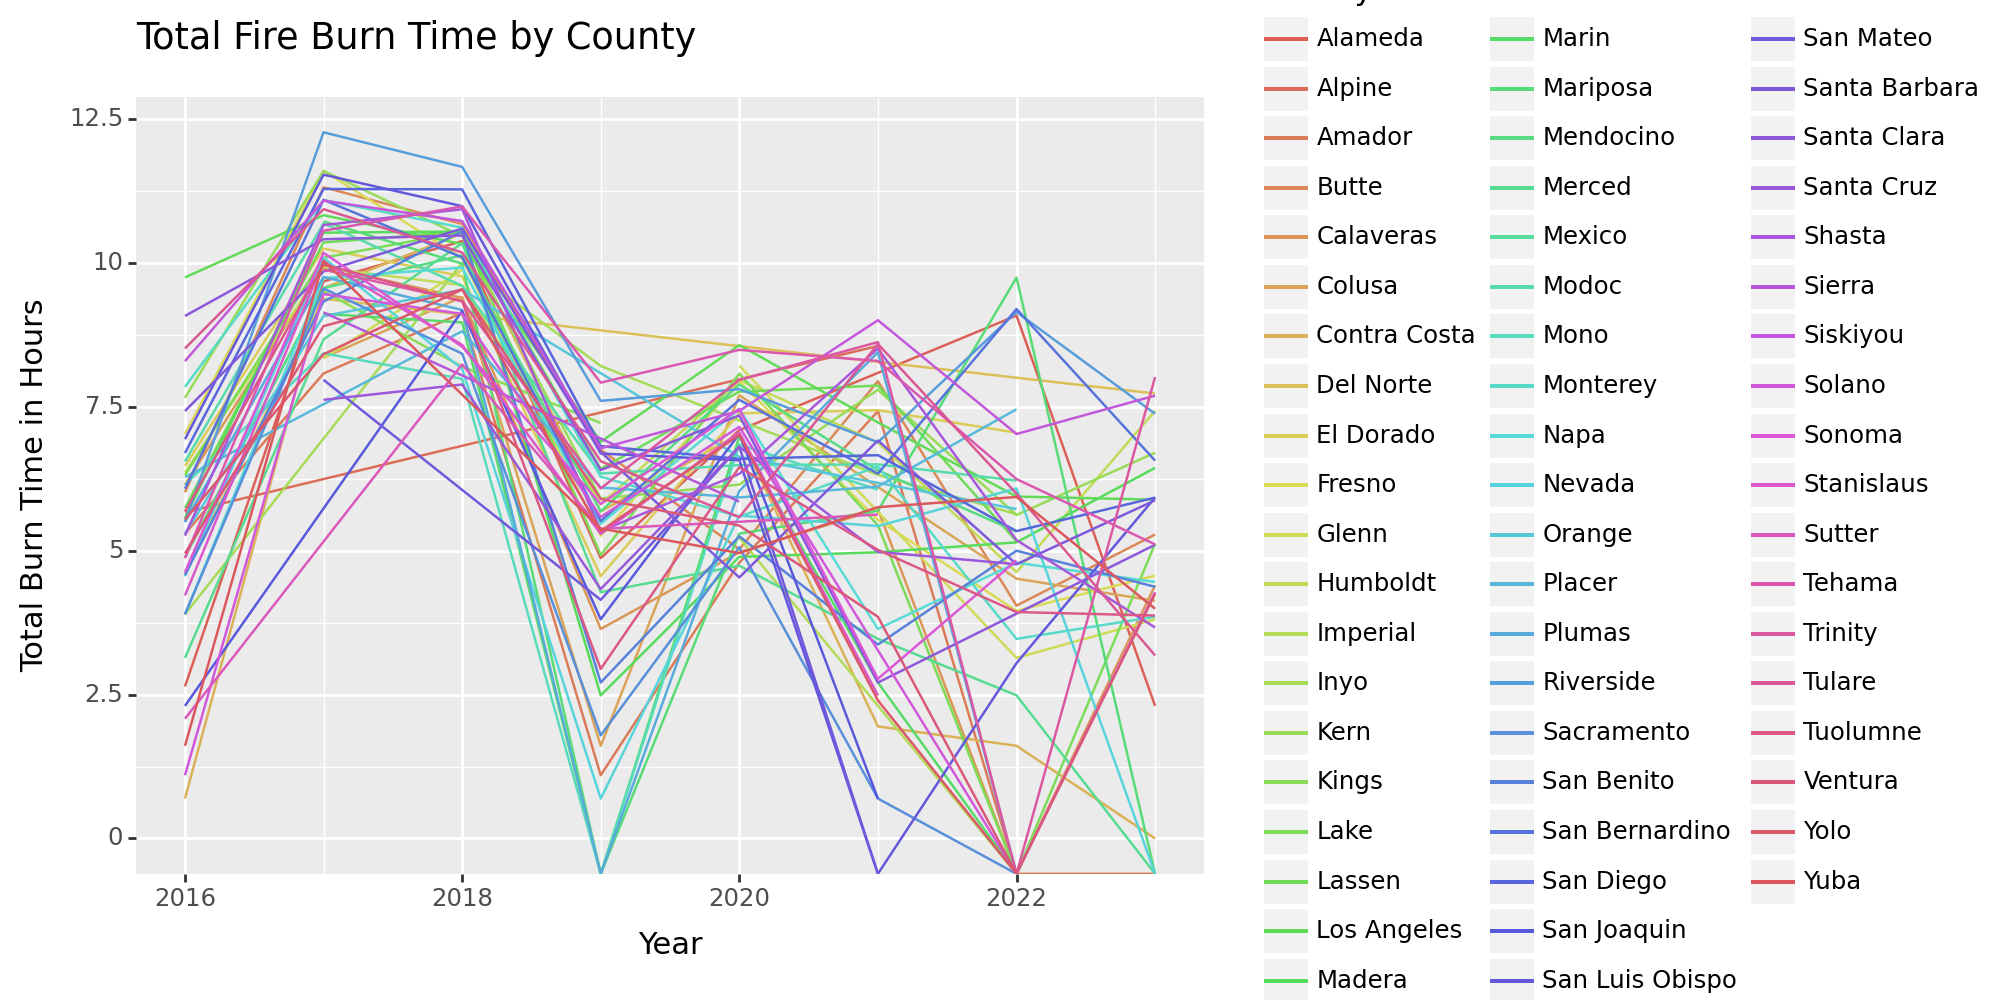

<Figure Size: (1000 x 500)>

In [19]:
(
    p9.ggplot(fire_df_final, p9.aes(x = "Year", y = "Log_Burn_Time", color = "County"))
    + p9.geom_line()
    + p9.theme(figure_size = (10, 5))
    + p9.labs(title = "Total Fire Burn Time by County",
           x = "Year",
           y = "Total Burn Time in Hours")
)

In [145]:
mean_fire_df = fire_df_final.groupby(['Year']).agg({'Total_Burn_Time': 'sum', 'AcresBurned': 'sum'}).reset_index()

mean_fire_df['Log_Burn_Time'] = np.log(mean_fire_df['Total_Burn_Time'])
mean_fire_df['Log_Acres_Burned'] = np.log(mean_fire_df['AcresBurned'])

mean_fire_df

,Year,Total_Burn_Time,AcresBurned,Log_Burn_Time,Log_Acres_Burned
0,2016,52247,505622,10.863738,13.133545
1,2017,1714962,1688745,14.354901,14.339496
2,2018,1286354,3356222,14.067322,15.026326
3,2019,23634,283218,10.070442,12.553972
4,2020,64539,12890750,11.075025,16.372021
5,2021,60497,7038054,11.010349,15.766842
6,2022,54328,360004,10.902795,12.793870
7,2023,15851,311341,9.670988,12.648644


C:\Users\cheif\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_boxplot : Removed 23 rows containing non-finite values.


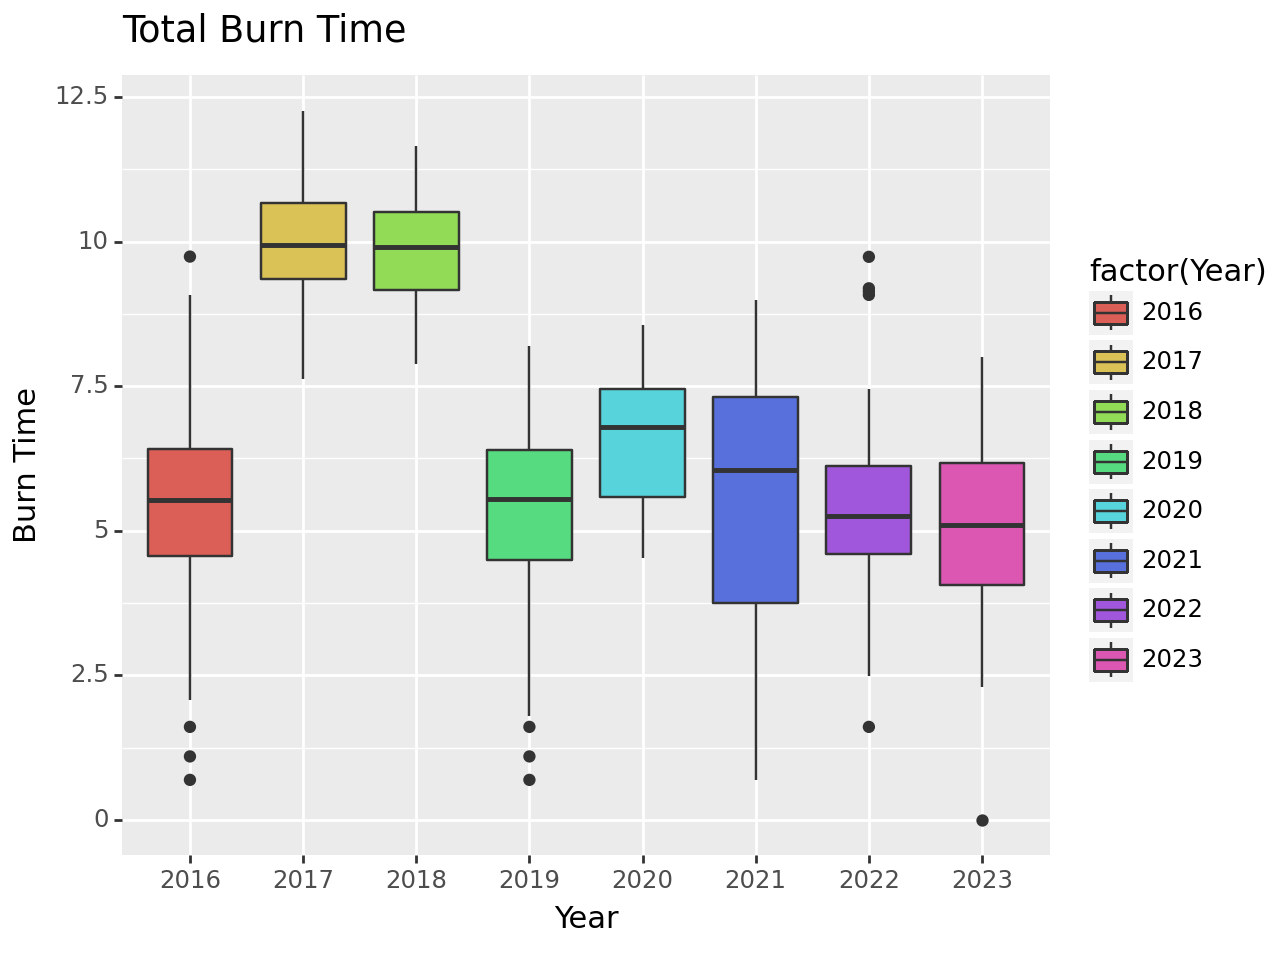

<Figure Size: (640 x 480)>

In [59]:
( 
    p9.ggplot(fire_df_final, p9.aes(x="factor(Year)", y="Log_Burn_Time", fill='factor(Year)')) 
    + p9.geom_boxplot()
    + p9.labs(title = "Total Burn Time", x = "Year", y = "Burn Time")
)

C:\Users\cheif\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_boxplot : Removed 8 rows containing non-finite values.


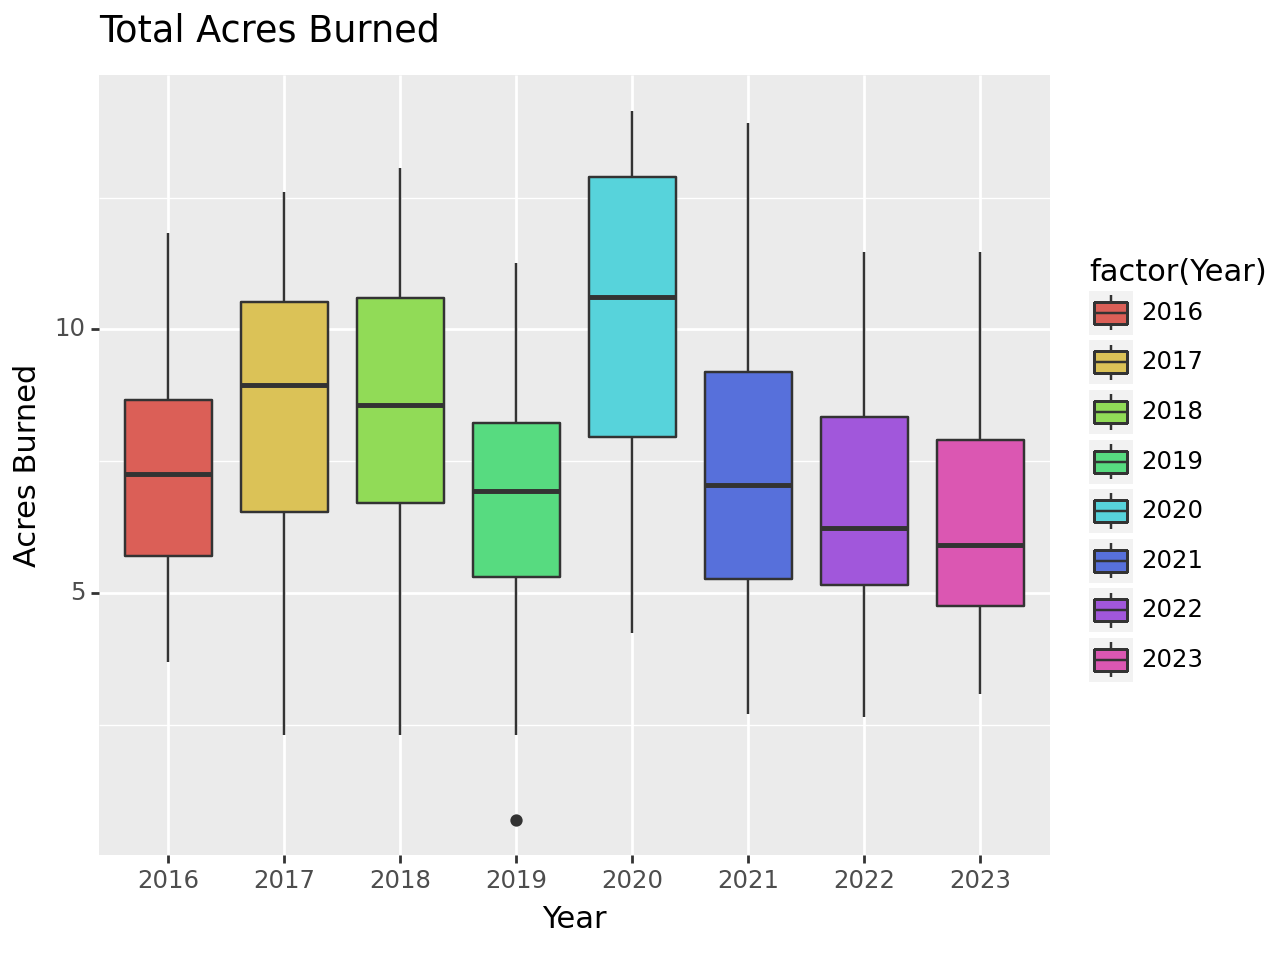

<Figure Size: (640 x 480)>

In [87]:
( 
    p9.ggplot(fire_df_final, p9.aes(x="factor(Year)", y="Log_Acres_Burned", fill='factor(Year)')) 
    + p9.geom_boxplot()
    + p9.labs(title = "Total Acres Burned", x = "Year", y = "Acres Burned")
)

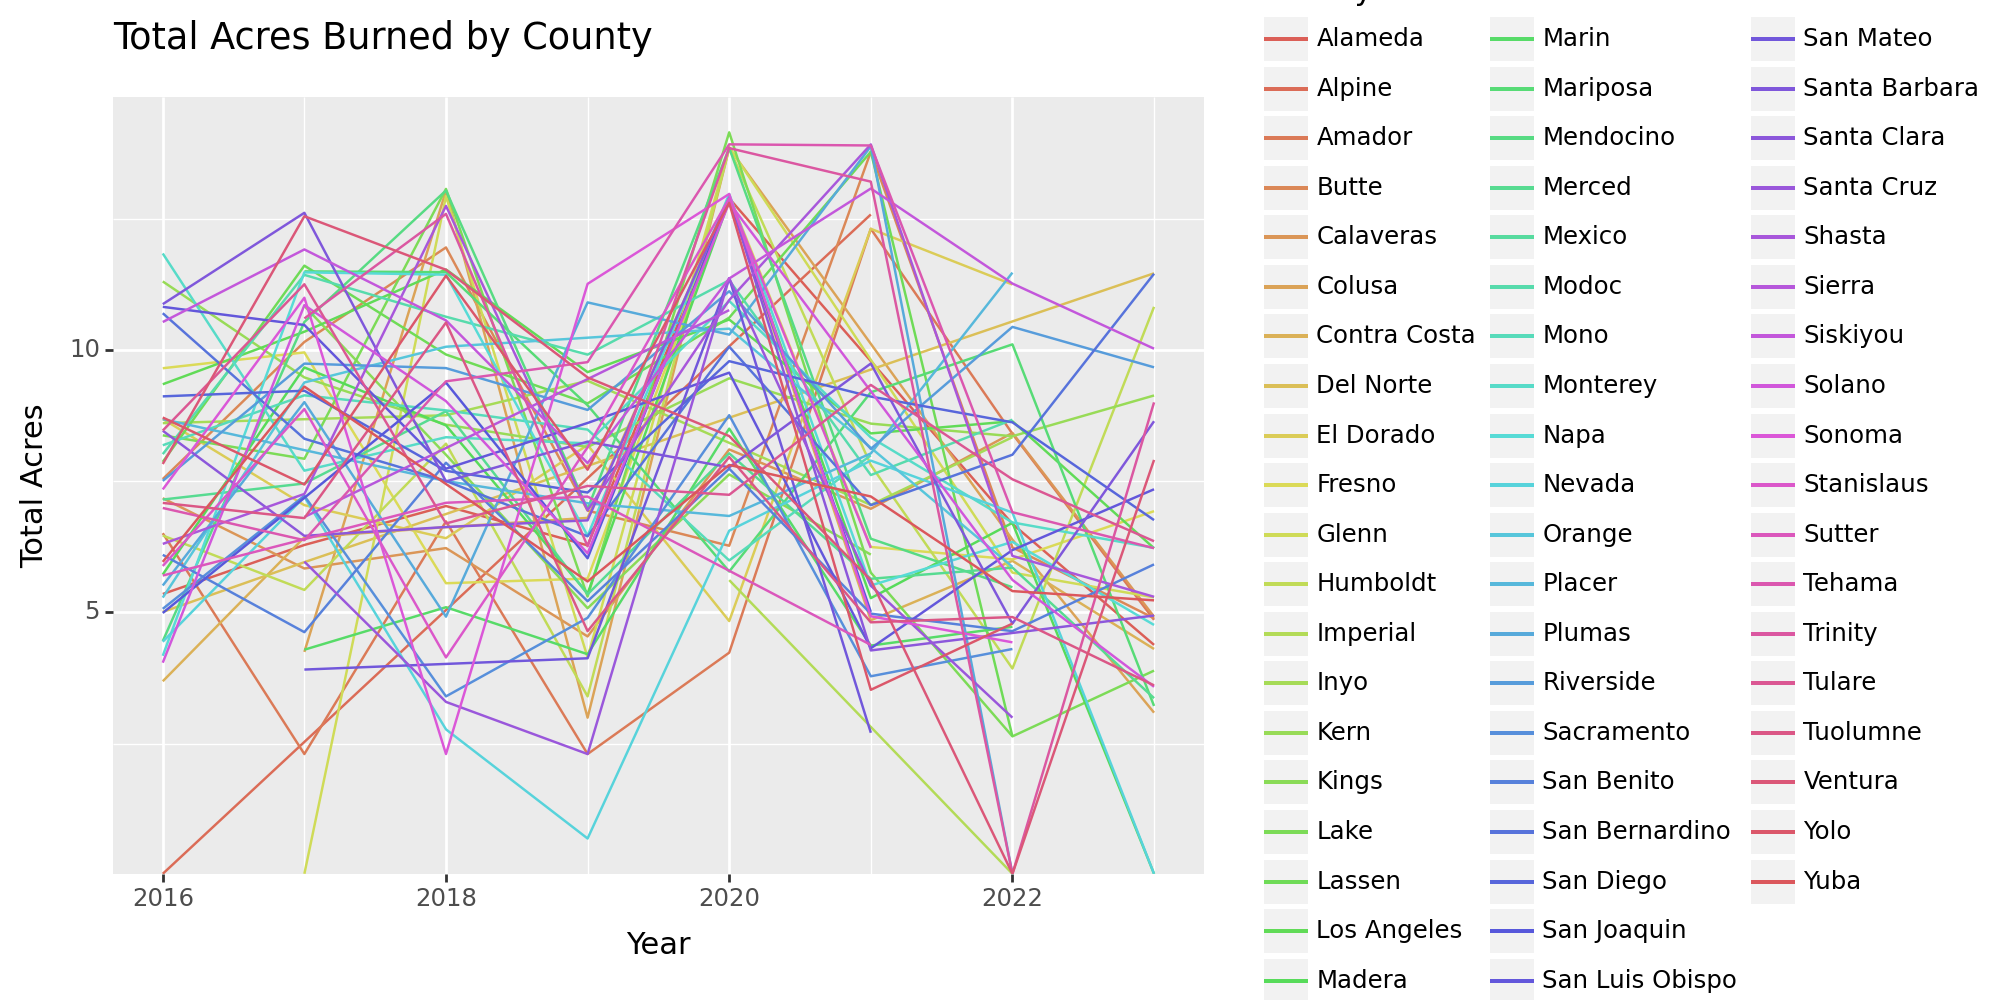

<Figure Size: (1000 x 500)>

In [86]:
(
    p9.ggplot(fire_df_final, p9.aes(x = "Year", y = "Log_Acres_Burned", color = "County"))
    + p9.geom_line()
    + p9.theme(figure_size = (10, 5))
    + p9.labs(title = "Total Acres Burned by County",
           x = "Year",
           y = "Total Acres")
)

In [21]:
# Aggregating the ebird_df to have total observations per county per year

ebird_df['Year'] = pd.to_datetime(ebird_df['Date']).dt.year
ebird_df['Species_Count'] = ebird_df['Species_Count'].astype(int)
ebird_df

,County,Species_Count,Date,Year
0,Los Angeles,1,12-15-2023,2023
1,Los Angeles,1,12-14-2023,2023
2,Los Angeles,4,12-14-2023,2023
3,Los Angeles,3,12-14-2023,2023
4,Los Angeles,10,12-14-2023,2023
...,...,...,...,...
19060,Calaveras,1,11-22-2018,2018
19061,Calaveras,1,11-22-2018,2018
19062,Calaveras,1,10-11-2018,2018
19063,Calaveras,2,05-25-2018,2018


In [25]:
ebird_df_final = ebird_df.groupby(['County','Year']).agg({'Species_Count': 'sum'}).reset_index()
ebird_df_final['Log_Species_Count'] = np.log(ebird_df_final['Species_Count'])
ebird_df_final

,County,Year,Species_Count,Log_Species_Count
0,Alameda,2016,2,0.693147
1,Alameda,2017,4,1.386294
2,Alameda,2018,5,1.609438
3,Alameda,2019,5,1.609438
4,Alameda,2020,12,2.484907
...,...,...,...,...
447,Yuba,2019,2,0.693147
448,Yuba,2020,8,2.079442
449,Yuba,2021,8,2.079442
450,Yuba,2022,15,2.708050


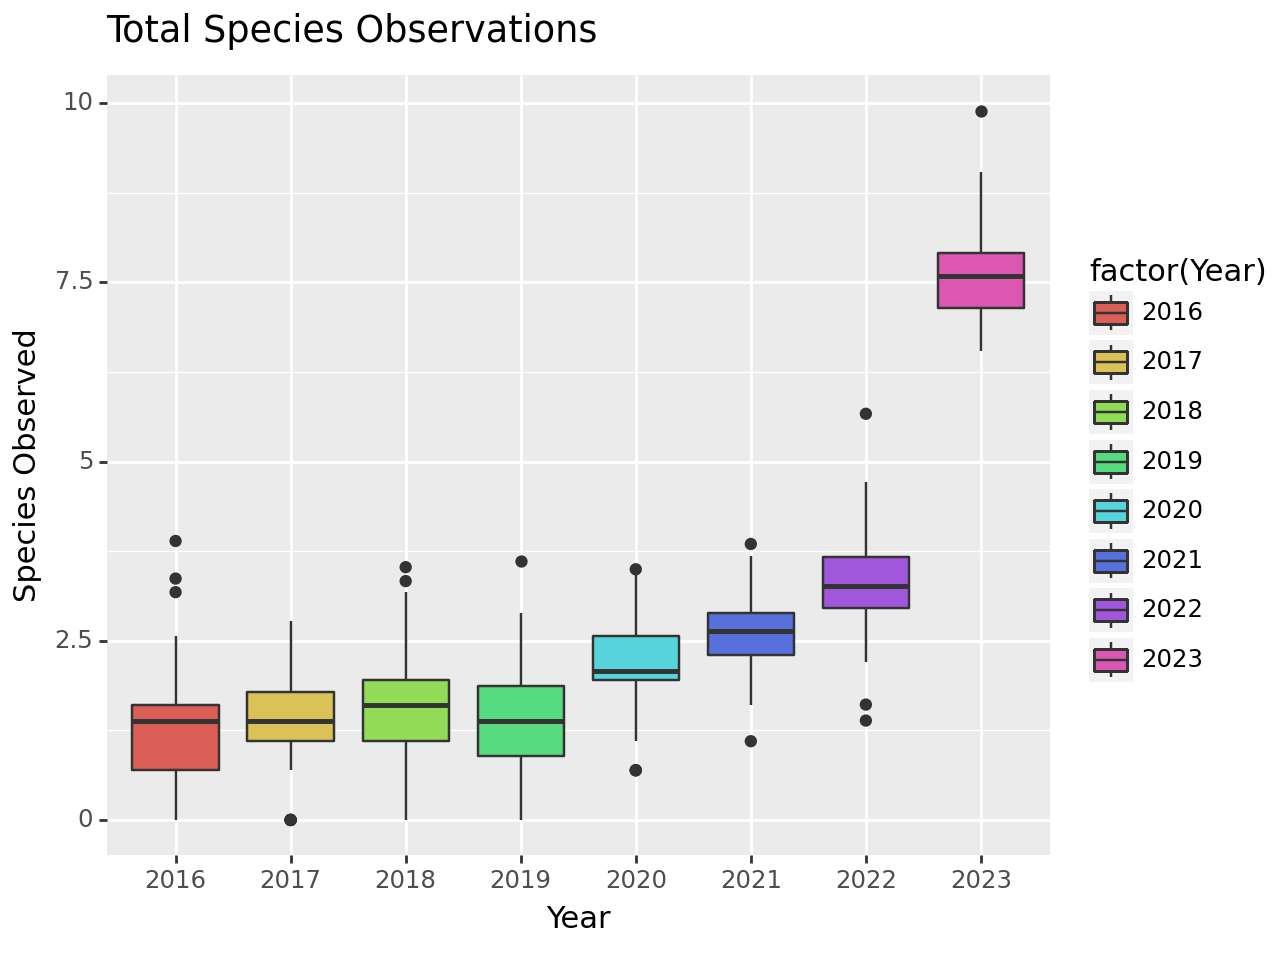

<Figure Size: (640 x 480)>

In [61]:
( 
    p9.ggplot(ebird_df_final, p9.aes(x="factor(Year)", y="Log_Species_Count", fill='factor(Year)')) 
    + p9.geom_boxplot()
    + p9.labs(title = "Total Species Observations", x = "Year", y = "Species Observed")
)

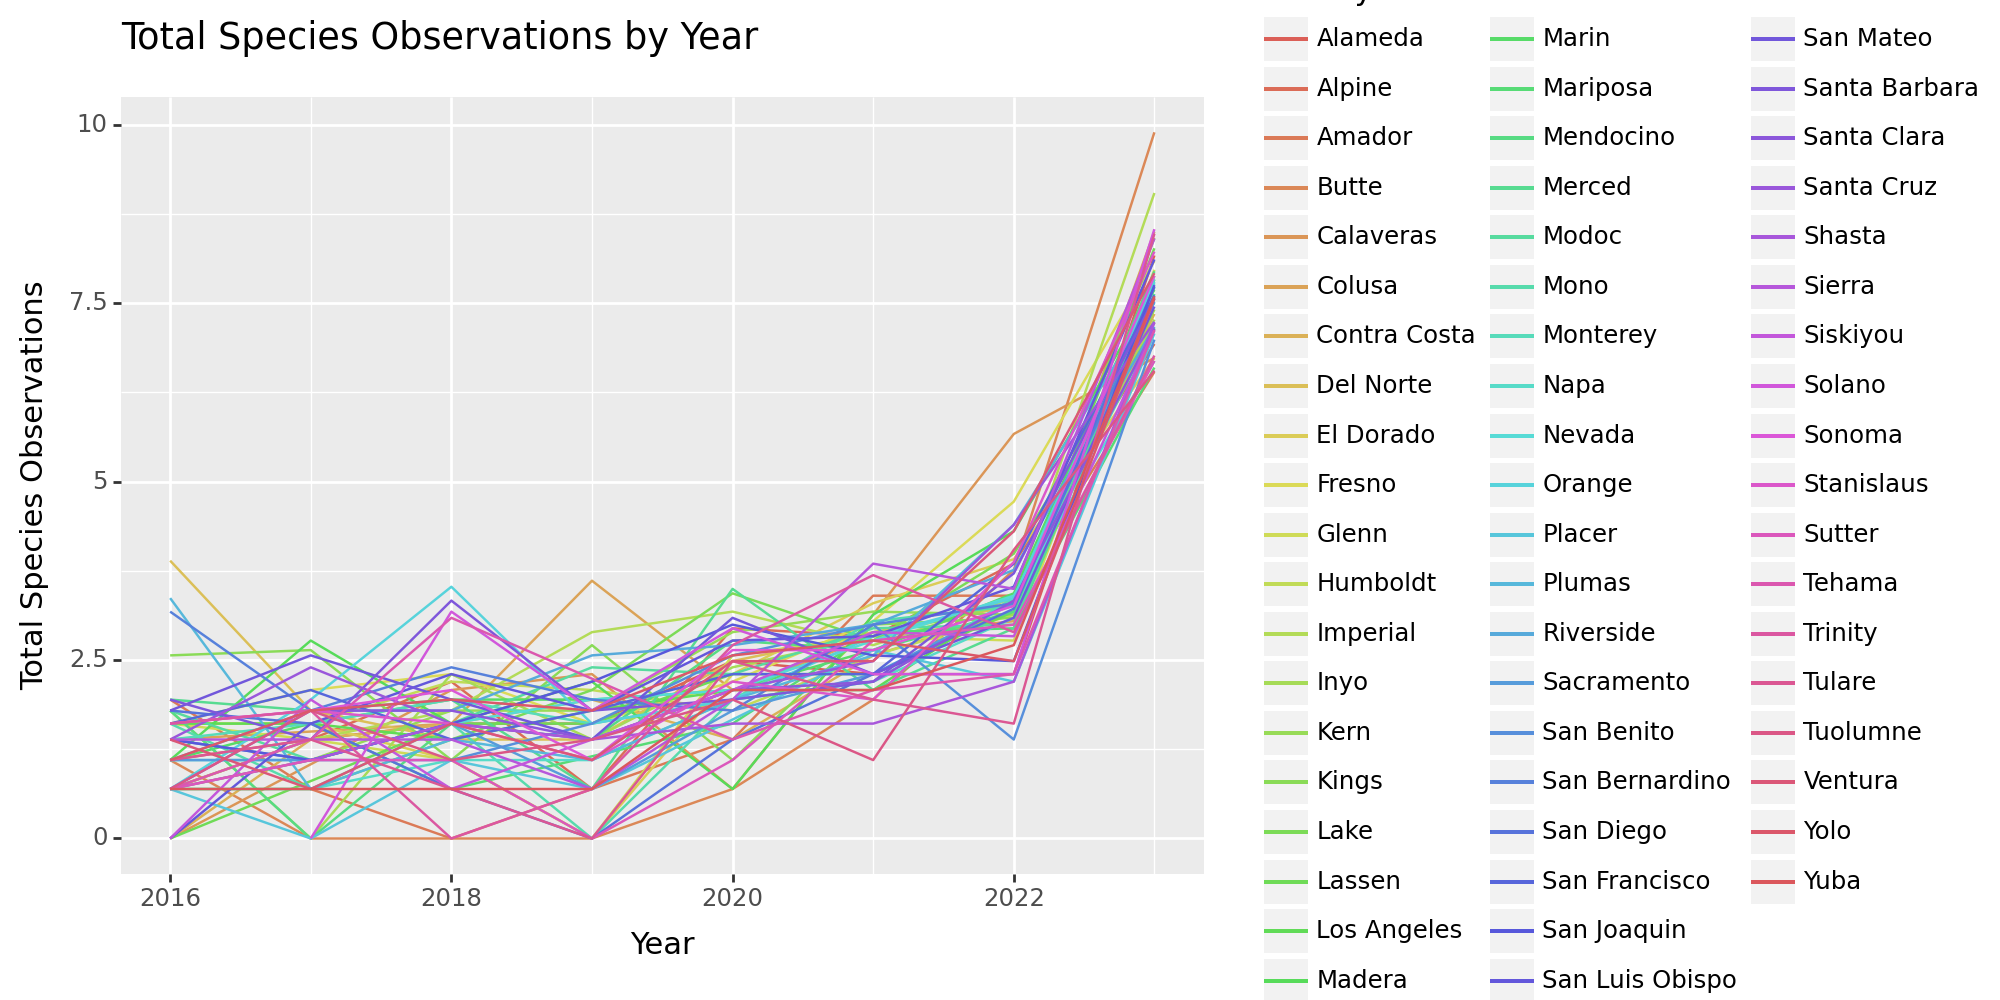

<Figure Size: (1000 x 500)>

In [33]:
(
    p9.ggplot(ebird_df_final, p9.aes(x = "Year", y = "Log_Species_Count", color = "County"))
    + p9.geom_line()
    + p9.theme(figure_size = (10, 5))
    + p9.labs(title = "Total Species Observations by Year",
           x = "Year",
           y = "Total Species Observations")
)

In [34]:
subset_ebird_df = ebird_df_final[ebird_df_final['Year'] <= 2019]

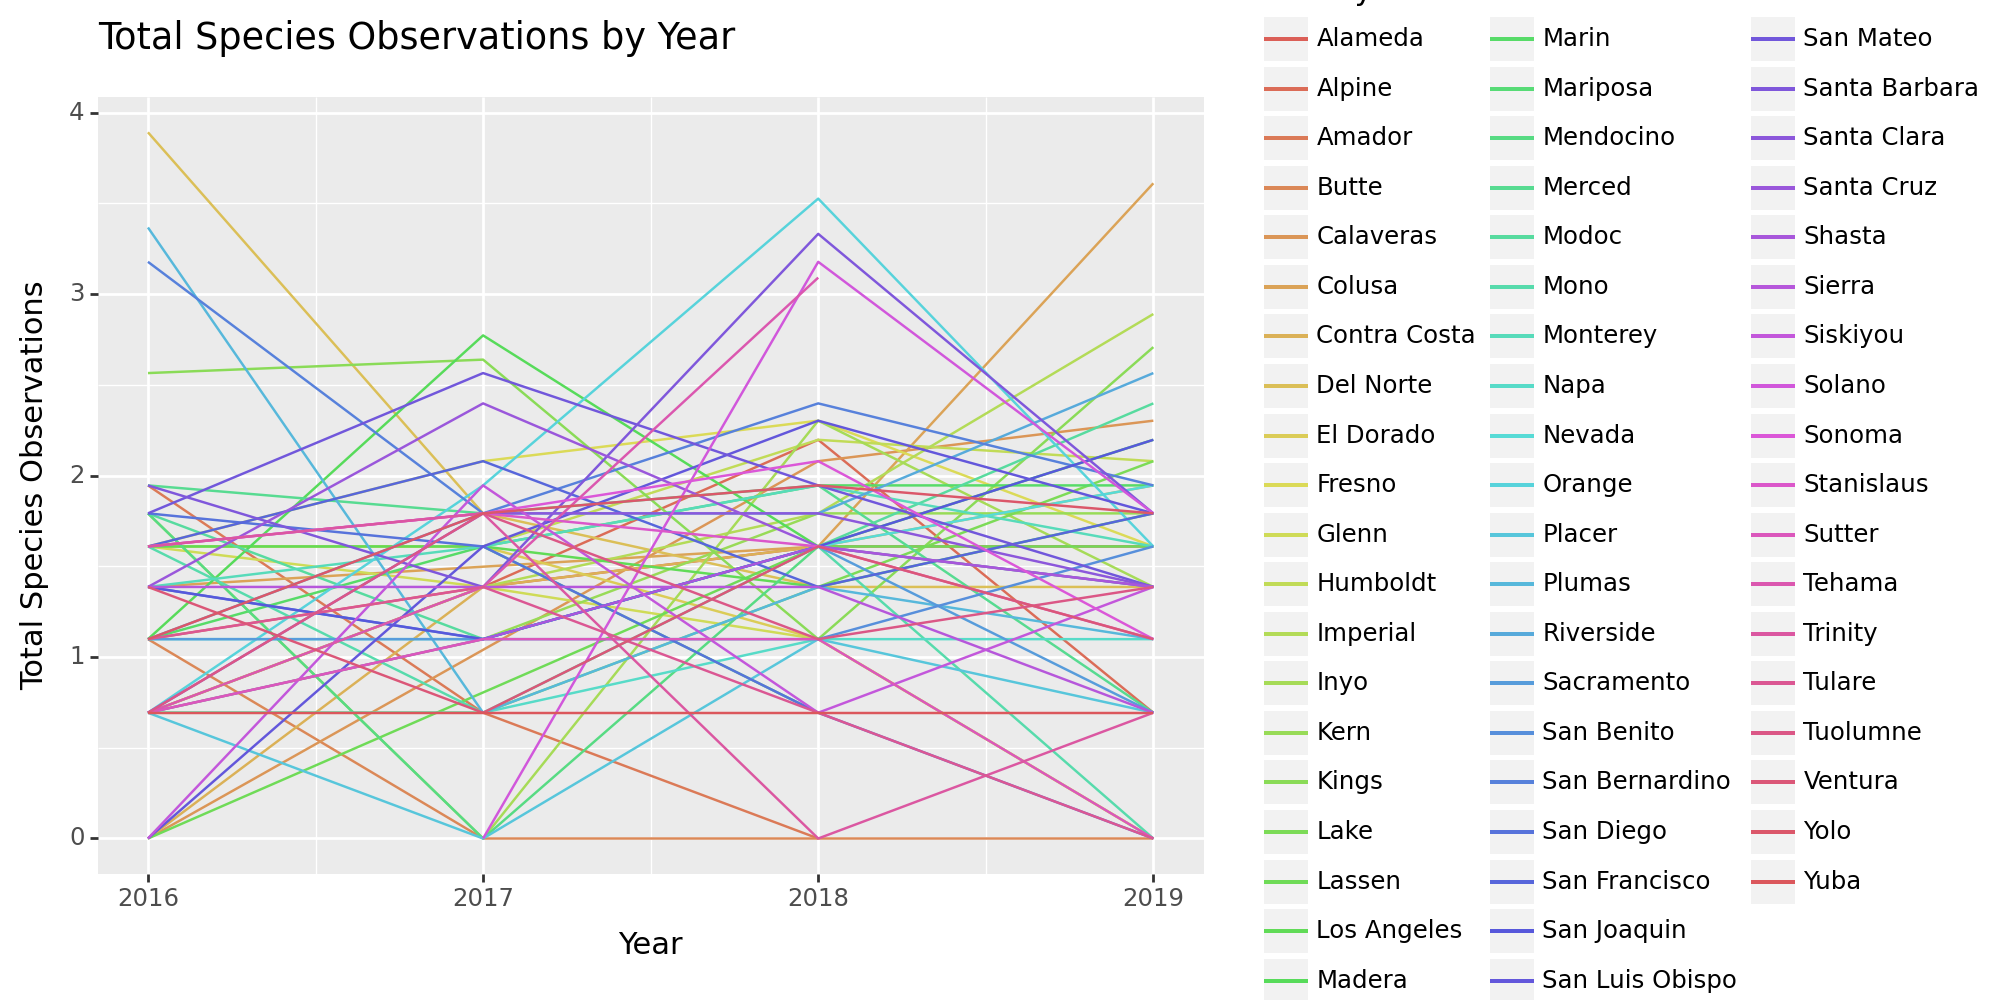

<Figure Size: (1000 x 500)>

In [35]:
(
    p9.ggplot(subset_ebird_df, p9.aes(x = "Year", y = "Log_Species_Count", color = "County"))
    + p9.geom_line()
    + p9.theme(figure_size = (10, 5))
    + p9.labs(title = "Total Species Observations by Year",
           x = "Year",
           y = "Total Species Observations")
)

In [36]:
final_merged_df = pd.merge(subset_ebird_df, fire_df_final, on=['Year', 'County'], how='inner')

In [37]:
final_merged_df

,County,Year,Species_Count,Log_Species_Count,Total_Burn_Time,AcresBurned,Log_Burn_Time,Log_Acres_Burned
0,Alameda,2016,2,0.693147,14,211,2.639057,5.351858
1,Alameda,2017,4,1.386294,15879,537,9.672753,6.285998
2,Alameda,2018,5,1.609438,31946,1128,10.371802,7.028201
3,Alameda,2019,5,1.609438,130,533,4.867534,6.278521
4,Alpine,2016,3,1.098612,288,0,5.662960,-inf
...,...,...,...,...,...,...,...,...
187,Yolo,2017,6,1.791759,4487,1700,8.408940,7.438384
188,Yolo,2018,7,1.945910,13787,90836,9.531481,11.416811
189,Yolo,2019,6,1.791759,208,2253,5.337538,7.720018
190,Yuba,2016,2,0.693147,5,389,1.609438,5.963579


In [38]:
bokeh.io.output_notebook()

Loading BokehJS ...

In [39]:
# Set up the slider.
start = final_merged_df["Year"].min()
end = final_merged_df["Year"].max()
slider = bokeh.models.Slider(start = start, end = end, step = 1, value = start)
years = final_merged_df["Year"].unique()

In [40]:
# Set up figure.
p = figure(title = str(start),
           width = 800, height = 400,
           x_range = (6.9, 8.5), y_range = (0.25, 0.75))
p.xaxis.axis_label = "Total Fire Burn Time"
p.yaxis.axis_label = "Bird Species Diversity"

In [41]:
# Set up data sources.
data = final_merged_df.copy()
data["Year"] = data["Year"].astype(str)
source = bokeh.models.ColumnDataSource(data)
view = bokeh.models.CDSView(filter = bokeh.models.GroupFilter(
    column_name = "Year", group = str(start)))

In [42]:
# Add the plot.
p.scatter("Log_Burn_Time",
          "Log_Species_Count",
          size = "Log_Acres_Burned",
          source = source, view = view, fill_alpha = 0.2)

GlyphRenderer(id='p1085', ...)

In [43]:
# ------------------------------------------------------------
# Set up the JavaScript callback.
# Use cb_obj to refer to the caller widget from a JavaScript callback.
callback = bokeh.models.CustomJS(
    args = {"source": source,
            "view": view,
            "figure": p,
            "years": years},
    code = """
    // This is the JavaScript code that will run whenever the slider is changed.
    // You can use the console.log() function to print values.

    var year = 1800;
    var best_d = 50;
    for (var y of years) {
        var d = Math.abs(y - cb_obj.value);

        if (d < best_d) {
            year = y;
            best_d = d;
        }
    }

    var value = year.toString();
    view.filters[0].group = value;
    figure.title.text = value;

    // Let Bokeh know the data source has changed.
    source.change.emit();
""")

slider.js_on_change("value", callback)

# ------------------------------------------------------------

In [129]:
# Set up layout and display.
layout = bokeh.layouts.Column(slider, p)
show(layout)

In [146]:
# Group each layer by year
fg_2023 = folium.FeatureGroup(name='2023')
fg_2022 = folium.FeatureGroup(name='2022')
fg_2021 = folium.FeatureGroup(name='2021')
fg_2020 = folium.FeatureGroup(name='2020')
fg_2019 = folium.FeatureGroup(name='2019')
fg_2018 = folium.FeatureGroup(name='2018')
fg_2017 = folium.FeatureGroup(name='2017')
fg_2016 = folium.FeatureGroup(name='2016')

m = folium.Map(location = [36.7783, -119.4179], zoom_start = 5)

cols = ["Year", "AcresBurned", "Latitude", "Longitude"]
for year, name, lat, lng in fire_df[cols].itertuples(index = False):
    try:
        int(year)
    except:
        continue
    if int(year) == 2023:
        popup = folium.Popup(name, parse_html = True)
        circle = folium.Circle([float(lat), float(lng)], color = "red", radius = 10, popup = popup)
        circle.add_to(fg_2023)
    elif int(year) == 2022:
        popup = folium.Popup(name, parse_html = True)
        circle = folium.Circle([float(lat), float(lng)], color = "red", radius = 10, popup = popup)
        circle.add_to(fg_2022)
    elif int(year) == 2021:
        popup = folium.Popup(name, parse_html = True)
        circle = folium.Circle([float(lat), float(lng)], color = "red", radius = 10, popup = popup)
        circle.add_to(fg_2021)
    elif int(year) == 2020:
        popup = folium.Popup(name, parse_html = True)
        circle = folium.Circle([float(lat), float(lng)], color = "red", radius = 10, popup = popup)
        circle.add_to(fg_2020)
    elif int(year) == 2019:
        popup = folium.Popup(name, parse_html = True)
        circle = folium.Circle([float(lat), float(lng)], color = "red", radius = 10, popup = popup)
        circle.add_to(fg_2019)
    elif int(year) == 2018:
        popup = folium.Popup(name, parse_html = True)
        circle = folium.Circle([float(lat), float(lng)], color = "red", radius = 10, popup = popup)
        circle.add_to(fg_2018)
    elif int(year) == 2017:
        popup = folium.Popup(name, parse_html = True)
        circle = folium.Circle([float(lat), float(lng)], color = "red", radius = 10, popup = popup)
        circle.add_to(fg_2017)
    elif int(year) == 2016:
        popup = folium.Popup(name, parse_html = True)
        circle = folium.Circle([float(lat), float(lng)], color = "red", radius = 10, popup = popup)
        circle.add_to(fg_2016)
    
fig = folium.Figure(width = 400, height = 370)
fig.add_child(m)

fg_2023.add_to(m)
fg_2022.add_to(m)
fg_2021.add_to(m)
fg_2020.add_to(m)
fg_2019.add_to(m)
fg_2018.add_to(m)
fg_2017.add_to(m)
fg_2016.add_to(m)

folium.LayerControl().add_to(m)
m

KeyError: "['Year'] not in index"

In [127]:
fig.save('California_Fires.html')

In [126]:
final_2021 = fire_df_final[fire_df_final['Year'] == 2021]

In [125]:
bio_df_merged = pd.merge(bio_df_subset, final_2021, on=['County'], how='inner')
bio_df_merged = bio_df_merged.drop_duplicates(subset='County')
bio_df_merged

,County,SpBioRnkEco,Year,Total_Burn_Time,AcresBurned,Log_Burn_Time,Log_Acres_Burned
0,Siskiyou,145,2021,8096,478345,8.999125,13.078088
2,Modoc,1318,2021,662,2035,6.495266,7.618251
3,Humboldt,265,2021,967,2462,6.874198,7.808729
